# Multi-condition signalling network inference

In this notebook we show how to infer signalling networks for a multicondition setting. \
Here we will use mouse RNA-seq data of a multicondition study, where we will compare normal to spontaneous leukemia and Sleeping-Beauty (SB) mediated leukemia. 

In the first part, we will show how to estimate Transcription Factor activities from gene expression data, following the Decoupler tutorial for functional analysis. \
Then, we will infer 2 networks for each of the 2 conditions and analyse differences.

- Author: Irene Rigato ([Francesca Finotello's group](https://computationalbiomedicinegroup.github.io/))
- Reviewers: Sophia Müller-Dott, Pablo Rodriguez-Mier

/Users/pablorodriguezmier/Documents/work/repos/pablormier/corneto/docs/tutorials/contrib/multi_condition_tutorial/.pixi/envs/default/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2025-06-27 18:26:34 | [INFO] Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`


2025-06-27 18:26:34 | [INFO] Downloading data from `https://omnipathdb.org/queries/interactions?format=json`


2025-06-27 18:26:34 | [INFO] Downloading data from `https://omnipathdb.org/queries/complexes?format=json`


2025-06-27 18:26:35 | [INFO] Downloading data from `https://omnipathdb.org/queries/annotations?format=json`


2025-06-27 18:26:35 | [INFO] Downloading data from `https://omnipathdb.org/queries/intercell?format=json`


2025-06-27 18:26:35 | [INFO] Downloading data from `https://omnipathdb.org/about?format=text`



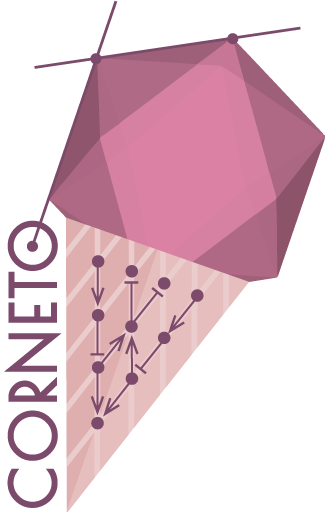

In [1]:
# --- Saezlab tools ---
# https://decoupler-py.readthedocs.io/
import gzip
import os
import shutil
import tempfile
import urllib.request

import decoupler as dc
import numpy as np

# https://omnipathdb.org/
import omnipath as op

# Additional packages
import pandas as pd

# --- Additional libs ---
# Pydeseq for differential expression analysis
from pydeseq2.dds import DefaultInference, DeseqDataSet
from pydeseq2.ds import DeseqStats

# https://saezlab.github.io/
import corneto as cn

cn.info()

In [2]:
max_time = 300
seed = 0

In [3]:
# loading GEO GSE148679 dataset
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE148679&format=file&file=GSE148679%5Fcounts%5Fgsea%5Fanalysis%2Etxt%2Egz"

adata = None
with tempfile.TemporaryDirectory() as tmpdirname:
    # Path for the gzipped file in the temp folder
    gz_file_path = os.path.join(tmpdirname, "counts.txt.gz")

    # Download the file
    with urllib.request.urlopen(url) as response:
        with open(gz_file_path, "wb") as out_file:
            shutil.copyfileobj(response, out_file)

    # Decompress the file
    decompressed_file_path = gz_file_path[:-3]  # Removing '.gz' extension
    with gzip.open(gz_file_path, "rb") as f_in:
        with open(decompressed_file_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    adata = pd.read_csv(decompressed_file_path, index_col=0, sep="\t").T

adata.head()

ID,Itm2a,Sergef,Fam109a,Dhx9,Fam71e2,Ssu72,Olfr1018,Eif2b2,Mks1,Hebp2,...,Olfr372,Gosr1,Ctsw,Ryk,Rhd,Pxmp4,Gm25500,4930455C13Rik,Prss39,Reg4
Ebf1.1,265,332,306,27823,0,2969,0,2614,231,6,...,0,2967,674,150,708,830,29,9,7,0
Ebf1.2,175,471,335,35978,0,3108,0,2924,192,0,...,0,2724,155,142,869,867,5,4,16,0
Ebf1.3,266,382,325,30367,0,3207,0,2940,211,7,...,0,2547,87,54,291,767,7,7,6,0
Ebf1.4,212,388,331,30406,0,3168,0,2871,209,8,...,0,2568,169,115,1244,829,5,1,4,0
PE.1,321,312,290,22272,0,2631,0,2236,109,10,...,0,2466,837,191,921,888,2,2,8,0


In [4]:
from anndata import AnnData

adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 53 × 24420

In [5]:
# renaming conditions for clarity
adata.obs["condition"] = np.select(
    [
        adata.obs.index.str.contains("WT"),
        adata.obs.index.str.contains("Pax5"),
        adata.obs.index.str.contains("Ebf1"),
        adata.obs.index.str.contains("Leuk"),
        adata.obs.index.str.contains("SB"),
    ],
    ["Normal", "Normal", "Normal", "Leukemic_spontaneous", "Leukemic_SB"],
    default="Normal",
)
# Visualize metadata
adata.obs["condition"].value_counts()

condition
Leukemic_SB             31
Normal                  15
Leukemic_spontaneous     7
Name: count, dtype: int64

## Splitting data for network inference and validation

We will validate the network for the comparison Leukemic_SB vs Normal (enough samples)

In [6]:
adata1 = adata[adata.obs["condition"].isin(["Normal", "Leukemic_spontaneous"])].copy()
adata2 = adata[adata.obs["condition"].isin(["Normal", "Leukemic_SB"])].copy()

## Differential expression analysis per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [7]:
# Obtain genes that pass the thresholds
dc.pp.filter_by_expr(
    adata1,
    group="condition",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.8,
)
adata1

AnnData object with n_obs × n_vars = 22 × 13585
    obs: 'condition'

In [8]:
# Estimation of differential expression
inference1 = DefaultInference()
dds1 = DeseqDataSet(
    adata=adata1,
    design_factors="condition",
    refit_cooks=True,
    inference=inference1,
)
dds1.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_36144/3807548237.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds1 = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Fitting dispersions...


... done in 0.51 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...


... done in 0.69 seconds.

Fitting LFCs...


... done in 0.35 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 35 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [9]:
stat_res_leu1 = DeseqStats(dds1, contrast=["condition", "Leukemic_spontaneous", "Normal"], inference=inference1)

stat_res_leu1.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Leukemic_spontaneous vs Normal
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ID                                                                              
1810058I24Rik   2306.834064       -0.520564  0.209899 -2.480062  1.313597e-02   
Lca5             588.642616       -0.161766  0.133110 -1.215284  2.242579e-01   
Ndufa10         4117.949269        0.398850  0.069244  5.760057  8.408572e-09   
Appbp2          2465.170707        0.118539  0.079705  1.487218  1.369574e-01   
Kifc5b           690.030303       -0.424162  0.099361 -4.268891  1.964470e-05   
...                     ...             ...       ...       ...           ...   
Cysltr2          286.562425       -4.825286  0.629909 -7.660289  1.855156e-14   
4632428C04Rik     56.421523       -2.093111  0.276118 -7.580482  3.442732e-14   
Rpl3l            139.393115       -2.158983  0.363642 -5.937118  2.900761e-09   
Zmym5           2503.994249   

... done in 0.30 seconds.



In [10]:
results_df1 = stat_res_leu1.results_df
results_df1.sort_values(by="padj", ascending=True, inplace=False).head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Egfl6,958.998149,-6.296339,0.244241,-25.779215,1.516794e-146,1.279074e-142
Polm,2883.081884,-7.255498,0.281539,-25.770836,1.883068e-146,1.279074e-142
Kdm5b,2202.514358,-5.510307,0.220788,-24.957441,1.772980e-137,8.028642e-134
Milr1,1647.365126,1.244237,0.050208,24.781408,1.422471e-135,4.831069e-132
Adgre5,10346.763067,-3.102891,0.125360,-24.751915,2.956557e-135,8.032965e-132


### Contrast 2: Leukemic_SB vs Normal

In [11]:
# Obtain genes that pass the thresholds
dc.pp.filter_by_expr(
    adata2,
    group="condition",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.8,
)
adata2

AnnData object with n_obs × n_vars = 46 × 13404
    obs: 'condition'

In [12]:
# Estimation of differential expression
inference2 = DefaultInference()
dds2 = DeseqDataSet(
    adata=adata2,
    design_factors="condition",
    refit_cooks=True,
    inference=inference2,
)
dds2.deseq2()

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_36144/3739200126.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds2 = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...


... done in 0.58 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...


... done in 0.72 seconds.

Fitting LFCs...


... done in 0.38 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 201 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.



In [13]:
stat_res_leu2 = DeseqStats(dds2, contrast=["condition", "Leukemic_SB", "Normal"], inference=inference2)

stat_res_leu2.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Leukemic_SB vs Normal
                   baseMean  log2FoldChange     lfcSE       stat  \
ID                                                                 
1810058I24Rik   2064.811388       -0.442806  0.118660  -3.731708   
Lca5             510.125522       -0.359272  0.149948  -2.395976   
Ndufa10         4456.508043        0.394199  0.090897   4.336742   
Appbp2          2462.624276        0.090457  0.064445   1.403626   
Kifc5b           592.263227       -0.501251  0.082228  -6.095893   
...                     ...             ...       ...        ...   
Cysltr2          138.715435       -5.529876  0.471282 -11.733688   
4632428C04Rik     30.799835       -2.844812  0.312001  -9.117946   
Rpl3l            105.987870       -1.395339  0.433373  -3.219718   
Zmym5           2220.329783       -0.312692  0.074025  -4.224160   
Calr           35244.098802        0.385481  0.089990   4.283597   

                     pvalue          padj  
I

... done in 0.28 seconds.



In [14]:
results_df2 = stat_res_leu2.results_df
results_df2.sort_values(by="padj", ascending=True, inplace=False).head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Mfsd2b,2252.744179,-9.412063,0.308793,-30.480193,4.769906e-204,6.393582e-200
Itga2b,8434.243135,-11.914356,0.401437,-29.679285,1.421308e-193,9.525603e-190
Adgrl4,148.349960,-9.117488,0.322229,-28.295029,3.978579e-176,1.777629e-172
Gp1ba,2396.209744,-8.226071,0.323265,-25.446856,7.648486e-143,2.563008e-139
Ppbp,17321.675345,-15.613716,0.621843,-25.108767,3.989417e-139,1.069483e-135


## Prior knowledge with Decoupler and Omnipath

In [15]:
# Retrieve CollecTRI gene regulatory network (through Omnipath)
collectri = dc.op.collectri(organism="mouse")
collectri.head()

,source,target,weight,resources,references,sign_decision
0,Myc,Tert,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,Spi1,Bglap3,1.0,ExTRI,10022617,default activation
2,Spi1,Bglap,1.0,ExTRI,10022617,default activation
3,Spi1,Bglap2,1.0,ExTRI,10022617,default activation
4,Smad3,Jun,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID


## TF activity inference per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [16]:
mat1 = results_df1[["stat"]].T.rename(index={"stat": "Leukemic_spontaneous.vs.Normal"})
mat1

ID,1810058I24Rik,Lca5,Ndufa10,Appbp2,Kifc5b,Dusp14,Snx13,Hdhd3,Dnajb14,Tesk2,...,Emc7,B3galt5,Tmprss4,Kif4,Alpk2,Cysltr2,4632428C04Rik,Rpl3l,Zmym5,Calr
Leukemic_spontaneous.vs.Normal,-2.480062,-1.215284,5.760057,1.487218,-4.268891,-4.893978,-0.736225,3.792193,-2.018379,-9.098806,...,1.907317,2.085353,9.76056,-10.189153,-1.853138,-7.660289,-7.580482,-5.937118,-2.313479,2.370808


In [17]:
tf_acts1, tf_pvals1 = dc.mt.ulm(data=mat1, net=collectri, verbose=True)
tf_acts1

2025-06-27 18:26:45 | [INFO] ulm - Running ulm


2025-06-27 18:26:45 | [INFO] Extracted omics mat with 1 rows (observations) and 13585 columns (features)


2025-06-27 18:26:45 | [INFO] Network adjacency matrix has 4442 unique features and 640 unique sources


2025-06-27 18:26:45 | [INFO] ulm - fitting 640 univariate models of 13585 observations (targets) with 13583 degrees of freedom


2025-06-27 18:26:45 | [INFO] ulm - adjusting p-values by FDR


2025-06-27 18:26:45 | [INFO] ulm - done


,Abl1,Ahr,Aire,Apex1,Ar,Arid1a,Arid1b,Arid3a,Arid3b,Arid4a,...,Zfpm1,Zfpm2,Zglp1,Zgpat,Zhx2,Zic1,Zic2,Zkscan3,Zkscan4,Zkscan7
Leukemic_spontaneous.vs.Normal,1.452444,-0.115657,-2.245577,0.882836,-0.298509,-0.176434,-0.632351,-0.453507,-1.821614,0.260513,...,-1.43915,0.110719,-1.527694,-0.947716,1.092937,0.530854,-0.030247,1.945875,1.945875,1.025677


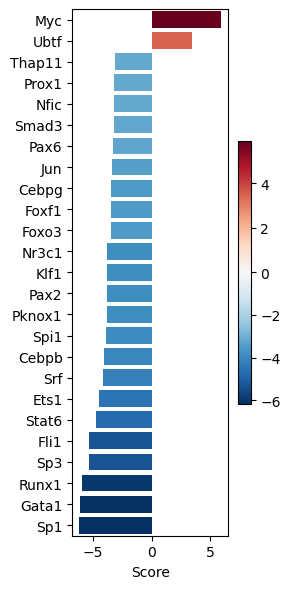

In [18]:
dc.pl.barplot(
    data=tf_acts1,
    name="Leukemic_spontaneous.vs.Normal",
    top=25,
    figsize=(3, 6),
)

### Contrast 2: Leukemic_SB vs Normal

In [19]:
mat2 = results_df2[["stat"]].T.rename(index={"stat": "Leukemic_SB.vs.Normal"})
mat2

ID,1810058I24Rik,Lca5,Ndufa10,Appbp2,Kifc5b,Snx13,Hdhd3,Dnajb14,Tesk2,Adnp,...,Emc7,B3galt5,Tmprss4,Kif4,Alpk2,Cysltr2,4632428C04Rik,Rpl3l,Zmym5,Calr
Leukemic_SB.vs.Normal,-3.731708,-2.395976,4.336742,1.403626,-6.095893,-0.045633,6.58726,1.804979,-4.887532,1.097428,...,2.795666,3.052277,6.874866,-9.738949,1.052295,-11.733688,-9.117946,-3.219718,-4.22416,4.283597


In [20]:
tf_acts2, tf_pvals2 = dc.mt.ulm(data=mat2, net=collectri, verbose=True)
tf_acts2

2025-06-27 18:26:46 | [INFO] ulm - Running ulm


2025-06-27 18:26:46 | [INFO] Extracted omics mat with 1 rows (observations) and 13404 columns (features)


2025-06-27 18:26:46 | [INFO] Network adjacency matrix has 4378 unique features and 625 unique sources


2025-06-27 18:26:46 | [INFO] ulm - fitting 625 univariate models of 13404 observations (targets) with 13402 degrees of freedom


2025-06-27 18:26:46 | [INFO] ulm - adjusting p-values by FDR


2025-06-27 18:26:46 | [INFO] ulm - done


,Abl1,Ahr,Aire,Apex1,Ar,Arid1a,Arid1b,Arid3a,Arid3b,Arid4a,...,Zfpm1,Zfpm2,Zglp1,Zgpat,Zhx2,Zic1,Zic2,Zkscan3,Zkscan4,Zkscan7
Leukemic_SB.vs.Normal,1.198683,0.664987,-0.932035,1.417199,0.441126,0.676737,-1.148896,-0.229277,-1.489196,0.92969,...,-1.618176,-0.165154,-0.623824,-1.382751,1.35549,0.659029,-0.049623,1.390877,1.390877,1.316184


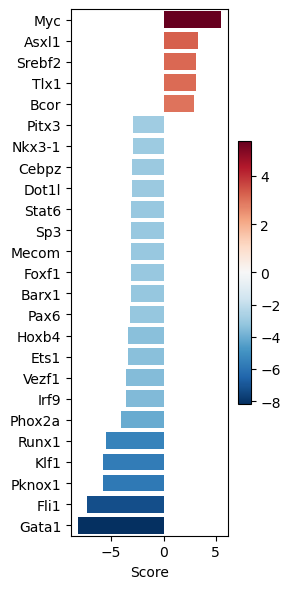

In [21]:
dc.pl.barplot(
    data=tf_acts2,
    name="Leukemic_SB.vs.Normal",
    top=25,
    figsize=(3, 6),
)

## Retrieving potential receptors per condition

In [22]:
# We obtain ligand-receptor interactions from Omnipath, and we keep only the receptors
# This is our list of a prior potential receptors from which we will infer the network
unique_receptors = set(
    op.interactions.LigRecExtra.get(organisms="mouse", genesymbols=True)["target_genesymbol"].values.tolist()
)
len(unique_receptors)

849

###  Contrast 1: Leukemic_spontaneous vs Normal

In [23]:
df_de_receptors1 = results_df1.loc[results_df1.index.intersection(unique_receptors)]
df_de_receptors1 = df_de_receptors1.sort_values(by="stat", ascending=False)

In [24]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors1 = df_de_receptors1.head(30)
df_top_receptors1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Mrc1,314.324326,3.312083,0.179667,18.434602,6.932705e-76,2.943150e-73
St14,1073.819725,1.904158,0.116095,16.401736,1.858495e-60,3.078982e-58
Cd48,5533.470898,0.664655,0.054604,12.172306,4.365699e-34,1.215328e-32
Ifngr1,6551.268902,1.418280,0.120961,11.725146,9.473804e-32,2.181384e-30
Lrrc4c,82.859784,10.019258,0.895652,11.186547,4.745541e-29,8.584311e-28


### Contrast 2: Leukemic_SB vs Normal

In [25]:
df_de_receptors2 = results_df2.loc[results_df2.index.intersection(unique_receptors)]
df_de_receptors2 = df_de_receptors2.sort_values(by="stat", ascending=False)

In [26]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors2 = df_de_receptors2.head(30)
df_top_receptors2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Lsr,770.417182,4.360408,0.346097,12.598814,2.143445e-36,8.425435e-35
Ptprs,5164.424536,1.303309,0.109463,11.906393,1.096177e-32,3.257906e-31
Nlgn2,1309.701665,1.950302,0.165263,11.801208,3.847470e-32,1.106684e-30
Cd244,2529.473998,2.992844,0.255033,11.735143,8.418380e-32,2.345945e-30
Lrrc4c,267.125842,10.650499,0.916744,11.617743,3.348651e-31,8.783820e-30


## Inferring intracellular signalling network with CORNETO


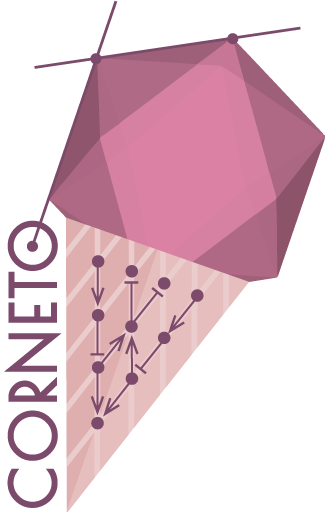

In [27]:
cn.info()

In [28]:
from corneto.methods.future import CarnivalFlow

# CarnivalFlow.show_citations()

## Setting prior knowledge graph

In [29]:
pkn = op.interactions.OmniPath.get(organisms="mouse", databases=["SIGNOR"], genesymbols=True)
pkn = pkn[pkn.consensus_direction == True]
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0C605,Q9QZC1,Prkg1,Trpc3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,P0C605,Q9WVC5,Prkg1,Trpc7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q8K2C7,Q9EPK8,Os9,Trpv4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P35821,Q91WD2,Ptpn1,Trpv6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P68040,Q8CIR4,Rack1,Trpm6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


In [30]:
pkn["interaction"] = pkn["is_stimulation"].astype(int) - pkn["is_inhibition"].astype(int)
sel_pkn = pkn[["source_genesymbol", "interaction", "target_genesymbol"]]
sel_pkn.head()

,source_genesymbol,interaction,target_genesymbol
0,Prkg1,-1,Trpc3
1,Prkg1,1,Trpc7
2,Os9,0,Trpv4
3,Ptpn1,-1,Trpv6
4,Rack1,-1,Trpm6


In [31]:
# We create the CORNETO graph by importing the edges and interaction
G = cn.Graph.from_sif_tuples([(r[0], r[1], r[2]) for _, r in sel_pkn.iterrows() if r[1] != 0])
G.shape  # nodes, edges

(4304, 9505)

## Identifying target TFs per condition

In [32]:
max_pval = 0.01

###  Contrast 1: Leukemic_spontaneous vs Normal

In [33]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs1 = (
    tf_acts1[tf_pvals1 <= max_pval].T.dropna().sort_values(by="Leukemic_spontaneous.vs.Normal", ascending=False)
)
significant_tfs1.head()

,Leukemic_spontaneous.vs.Normal
Myc,5.923504
Nr3c1,-3.811319
Klf1,-3.827703
Pax2,-3.833334
Pknox1,-3.854036


In [34]:
# We keep only the ones in the PKN graph
measurements1 = significant_tfs1.loc[significant_tfs1.index.intersection(G.V)].to_dict()[
    "Leukemic_spontaneous.vs.Normal"
]
measurements1

{'Myc': 5.9235035317894855,
 'Nr3c1': -3.8113193546675745,
 'Pax2': -3.833334174850489,
 'Pknox1': -3.8540363164880644,
 'Spi1': -3.8784486226011565,
 'Cebpb': -4.040106259374742,
 'Srf': -4.189355333236107,
 'Ets1': -4.531331302590852,
 'Stat6': -4.773632881709543,
 'Fli1': -5.33776968520547,
 'Sp3': -5.344046528477468,
 'Runx1': -5.974558044625292,
 'Gata1': -6.145310061493243,
 'Sp1': -6.183198826931179}

### Contrast 2: Leukemic_SB vs Normal

In [35]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs2 = tf_acts2[tf_pvals2 <= max_pval].T.dropna().sort_values(by="Leukemic_SB.vs.Normal", ascending=False)
significant_tfs2.head()

,Leukemic_SB.vs.Normal
Myc,5.455686
Phox2a,-4.102661
Runx1,-5.481558
Klf1,-5.749639
Pknox1,-5.823607


In [36]:
# We keep only the ones in the PKN graph
measurements2 = significant_tfs2.loc[significant_tfs2.index.intersection(G.V)].to_dict()["Leukemic_SB.vs.Normal"]
measurements2

{'Myc': 5.4556864114528985,
 'Phox2a': -4.102661149717304,
 'Runx1': -5.481558125441376,
 'Pknox1': -5.823606769114178,
 'Fli1': -7.269739674233043,
 'Gata1': -8.17854383650117}

In [37]:
def balance_dicts_by_top_abs(dict1, dict2, discretize=False):
    # Decide which is smaller and which is larger
    if len(dict1) <= len(dict2):
        small, large = dict1, dict2
    else:
        small, large = dict2, dict1

    n = len(small)
    # Take the n keys from large with the largest abs(values)
    top_large_items = sorted(large.items(), key=lambda kv: abs(kv[1]), reverse=True)[:n]

    # Prepare output dicts
    small_balanced = dict(small)  # already of size n
    large_balanced = dict(top_large_items)

    if discretize:
        small_balanced = {k: np.sign(v) for k, v in small_balanced.items()}
        large_balanced = {k: np.sign(v) for k, v in large_balanced.items()}

    return small_balanced, large_balanced


# Discretize not needed, but simplifies multi-cond analysis since both conditions have the same cost
d_measurements1, d_measurements2 = balance_dicts_by_top_abs(measurements1, measurements2, discretize=True)
d_measurements1

{'Myc': np.float64(1.0),
 'Phox2a': np.float64(-1.0),
 'Runx1': np.float64(-1.0),
 'Pknox1': np.float64(-1.0),
 'Fli1': np.float64(-1.0),
 'Gata1': np.float64(-1.0)}

In [38]:
d_measurements2

{'Sp1': np.float64(-1.0),
 'Gata1': np.float64(-1.0),
 'Runx1': np.float64(-1.0),
 'Myc': np.float64(1.0),
 'Sp3': np.float64(-1.0),
 'Fli1': np.float64(-1.0)}

## Creating a CARNIVAL problem per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [39]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs1 = {k: 0 for k in df_top_receptors1.index.intersection(G.V).values}
inputs1

{'Ifngr1': 0,
 'Lrrc4c': 0,
 'Tnfrsf11a': 0,
 'Cdon': 0,
 'Notch1': 0,
 'Ptprs': 0,
 'Nlgn2': 0,
 'Flt3': 0,
 'Ephb4': 0,
 'Il2rg': 0,
 'Marco': 0,
 'Axl': 0,
 'Tlr4': 0,
 'Ifngr2': 0,
 'Znrf3': 0}

In [40]:
# Create the dataset in standard format
carnival_data1 = dict()
for inp, v in inputs1.items():
    carnival_data1[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in d_measurements1.items():
    carnival_data1[out] = dict(value=v, role="output", mapping="vertex")
data1 = cn.Data.from_cdict({"sample1": carnival_data1})
data1

Data(n_samples=1, n_feats=[21])

### Contrast 2: Leukemic_SB vs Normal

In [41]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs2 = {k: 0 for k in df_top_receptors2.index.intersection(G.V).values}
inputs2

{'Ptprs': 0,
 'Nlgn2': 0,
 'Lrrc4c': 0,
 'Tnfrsf11a': 0,
 'Ifngr1': 0,
 'Marco': 0,
 'Ifngr2': 0,
 'Ctla4': 0,
 'Znrf3': 0,
 'Flt3': 0,
 'Ephb4': 0,
 'Il9r': 0,
 'Icam1': 0,
 'Axl': 0}

In [42]:
# Create the dataset in standard format
carnival_data2 = dict()
for inp, v in inputs2.items():
    carnival_data2[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in d_measurements2.items():
    carnival_data2[out] = dict(value=v, role="output", mapping="vertex")
data2 = cn.Data.from_cdict({"sample2": carnival_data2})
data2

Data(n_samples=1, n_feats=[20])

## Solving multi-condition CARNIVAL problem with CORNETO

In [43]:
data = cn.Data.from_cdict({"sample1": carnival_data1, "sample2": carnival_data2})
data

Data(n_samples=2, n_feats=[21 20])

In [44]:
from corneto.utils import check_gurobi

check_gurobi()

2025-06-27 18:26:47 | [INFO] Set parameter Username


2025-06-27 18:26:47 | [INFO] Set parameter LicenseID to value 2593994


2025-06-27 18:26:47 | [INFO] Academic license - for non-commercial use only - expires 2025-12-02


Gurobipy successfully imported.
Gurobi environment started successfully.
Starting optimization of the test model...
Test optimization was successful.
Gurobi environment disposed.
Gurobi is correctly installed and working.


True

In [45]:
def subgraph(G, inp, out):
    inp_s = set(G.V).intersection(inp)
    out_s = set(G.V).intersection(out)
    Gs = G.prune(inp_s, out_s)
    tot_inp = set(Gs.V).intersection(inp)
    tot_out = set(Gs.V).intersection(out)
    print(f"Inputs: ({len(tot_inp)}/{len(inp)}), Outputs: ({len(tot_out)}/{len(out)})")
    return Gs


Gs1 = subgraph(G, df_top_receptors1.index.tolist(), list(d_measurements1.keys()))
Gs2 = subgraph(G, df_top_receptors2.index.tolist(), list(d_measurements2.keys()))

Inputs: (7/30), Outputs: (5/6)


Inputs: (4/30), Outputs: (6/6)


In [46]:
c = CarnivalFlow(lambda_reg=0, indirect_rule_penalty=1)
P = c.build(G, data)

Unreachable vertices for sample: 12
Unreachable vertices for sample: 7


In [47]:
len(set(c.processed_graph.V).intersection(d_measurements1.keys()))

5

In [48]:
len(set(c.processed_graph.V).intersection(d_measurements2.keys()))

6

In [49]:
# How many TFs are in common between conditions?
s1 = set(c.processed_graph.V).intersection(d_measurements1.keys())
s2 = set(c.processed_graph.V).intersection(d_measurements2.keys())
for g in s1.intersection(s2):
    print(g, d_measurements1[g], d_measurements2[g])

Gata1 -1.0 -1.0
Fli1 -1.0 -1.0
Runx1 -1.0 -1.0
Myc 1.0 1.0


## Which is the best lambda to choose?

To choose a robust value of $\lambda$ we sample multiple solutions, as in the tutorial https://saezlab.github.io/corneto/dev/tutorials/network-sampler.html#vertex-based-perturbation. \
We define 3 metrics to choose $\lambda$: \
\
$sign\_agreement\_ratio = \frac{n.\:of\:nodes\:matching\:sign\:with\:stat\:value}{total\:n.\:of\:nodes}$ \
\
$de\_overlap\_ratio = \frac{n.\:of\:nodes\:also\:differentially\:expressed}{total\:n.\:of\:nodes}$ \
\
$overall\_agreement = \frac{sign\_agreement\_ratio\:+\:de\_overlap\_ratio}{2}$ 


In [50]:
# retrieving alternative network solutions. This snippet will take a while to run
from corneto.methods.sampler import sample_alternative_solutions

lambda_val = [0, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95]
other_optimal_v = dict()  # collecting the vertex sampled solutions for each lambda
index = dict()
for i in lambda_val:
    print("lambda: ", i)
    c = CarnivalFlow(lambda_reg=i, indirect_rule_penalty=1)
    P = c.build(G, data)
    vertex_results = sample_alternative_solutions(
        P,
        "vertex_value",
        percentage=0.03,
        scale=0.03,
        rel_opt_tol=0.05,
        max_samples=30,  # number of alternative solutions to sample
        solver_kwargs=dict(solver="gurobi", max_seconds=max_time, mip_gap=0.01, seed=seed),
    )
    other_optimal_v["lambda" + str(i)] = vertex_results["vertex_value"]
    index["lambda" + str(i)] = c.processed_graph.V

lambda:  0


Unreachable vertices for sample: 12
Unreachable vertices for sample: 7
Set parameter Username


2025-06-27 18:26:48 | [INFO] Set parameter Username


Set parameter LicenseID to value 2593994


2025-06-27 18:26:48 | [INFO] Set parameter LicenseID to value 2593994


Academic license - for non-commercial use only - expires 2025-12-02


2025-06-27 18:26:48 | [INFO] Academic license - for non-commercial use only - expires 2025-12-02


2025-06-27 18:26:51 | [INFO] [1/30] accepted (total accepted=1) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=68, rel.err=1.1250 (excluded from tol. check)


2025-06-27 18:26:52 | [INFO] [2/30] accepted (total accepted=2) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=89, rel.err=1.7812 (excluded from tol. check)


2025-06-27 18:26:53 | [INFO] [3/30] accepted (total accepted=3) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=68, rel.err=1.1250 (excluded from tol. check)


2025-06-27 18:26:55 | [INFO] [4/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=1) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=118, rel.err=2.6875 (excluded from tol. check)


2025-06-27 18:26:56 | [INFO] [5/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=2) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=138, rel.err=3.3125 (excluded from tol. check)


2025-06-27 18:26:58 | [INFO] [6/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=3) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=104, rel.err=2.2500 (excluded from tol. check)


2025-06-27 18:26:59 | [INFO] [7/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=4) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=103, rel.err=2.2188 (excluded from tol. check)


2025-06-27 18:27:01 | [INFO] [8/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=5) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=98, rel.err=2.0625 (excluded from tol. check)


2025-06-27 18:27:02 | [INFO] [9/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=6) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=82, rel.err=1.5625 (excluded from tol. check)


2025-06-27 18:27:03 | [INFO] [10/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=7) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=96, rel.err=2.0000 (excluded from tol. check)


2025-06-27 18:27:05 | [INFO] [11/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=8) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=0, rel.err=1.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=2, rel.err=2000000000.0000, regularization_edge_has_signal_OR: val=127, rel.err=2.9688 (excluded from tol. check)


2025-06-27 18:27:06 | [INFO] [12/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=9) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=123, rel.err=2.8438 (excluded from tol. check)


2025-06-27 18:27:08 | [INFO] [13/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=10) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=61, rel.err=0.9062 (excluded from tol. check)


2025-06-27 18:27:09 | [INFO] [14/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=11) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=98, rel.err=2.0625 (excluded from tol. check)


2025-06-27 18:27:10 | [INFO] [15/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=12) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=86, rel.err=1.6875 (excluded from tol. check)


2025-06-27 18:27:12 | [INFO] [16/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=13) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=88, rel.err=1.7500 (excluded from tol. check)


2025-06-27 18:27:13 | [INFO] [17/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=14) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=114, rel.err=2.5625 (excluded from tol. check)


2025-06-27 18:27:15 | [INFO] [18/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=15) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=99, rel.err=2.0938 (excluded from tol. check)


2025-06-27 18:27:16 | [INFO] [19/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=16) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=99, rel.err=2.0938 (excluded from tol. check)


2025-06-27 18:27:18 | [INFO] [20/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.6667) (total rejected=17) -> error_sample1_0: val=1, rel.err=0.6667, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=2, rel.err=2000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=98, rel.err=2.0625 (excluded from tol. check)


2025-06-27 18:27:20 | [INFO] [21/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=18) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=87, rel.err=1.7188 (excluded from tol. check)


2025-06-27 18:27:21 | [INFO] [22/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=19) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=84, rel.err=1.6250 (excluded from tol. check)


2025-06-27 18:27:22 | [INFO] [23/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=20) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=118, rel.err=2.6875 (excluded from tol. check)


2025-06-27 18:27:24 | [INFO] [24/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=21) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=103, rel.err=2.2188 (excluded from tol. check)


2025-06-27 18:27:25 | [INFO] [25/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=22) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=102, rel.err=2.1875 (excluded from tol. check)


2025-06-27 18:27:27 | [INFO] [26/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=23) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=110, rel.err=2.4375 (excluded from tol. check)


2025-06-27 18:27:28 | [INFO] [27/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=24) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=89, rel.err=1.7812 (excluded from tol. check)


2025-06-27 18:27:30 | [INFO] [28/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=25) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=96, rel.err=2.0000 (excluded from tol. check)


2025-06-27 18:27:31 | [INFO] [29/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=26) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=100, rel.err=2.1250 (excluded from tol. check)


2025-06-27 18:27:33 | [INFO] [30/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=27) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=96, rel.err=2.0000 (excluded from tol. check)


2025-06-27 18:27:33 | [INFO] Done. accepted=3, rejected=27, solutions returned=4


lambda:  0.01


Unreachable vertices for sample: 12
Unreachable vertices for sample: 7


2025-06-27 18:27:37 | [INFO] [1/30] accepted (total accepted=1) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=33, rel.err=1.2000 (excluded from tol. check)


2025-06-27 18:27:39 | [INFO] [2/30] accepted (total accepted=2) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=29, rel.err=0.9333 (excluded from tol. check)


2025-06-27 18:27:41 | [INFO] [3/30] accepted (total accepted=3) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=38, rel.err=1.5333 (excluded from tol. check)


2025-06-27 18:27:43 | [INFO] [4/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=1) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=38, rel.err=1.5333 (excluded from tol. check)


2025-06-27 18:27:45 | [INFO] [5/30] accepted (total accepted=4) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=35, rel.err=1.3333 (excluded from tol. check)


2025-06-27 18:27:47 | [INFO] [6/30] accepted (total accepted=5) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=44, rel.err=1.9333 (excluded from tol. check)


2025-06-27 18:27:48 | [INFO] [7/30] rejected (tol=0.05 violated by 'error_sample2_1' with rel.err=0.5000) (total rejected=2) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=37, rel.err=1.4667 (excluded from tol. check)


2025-06-27 18:27:51 | [INFO] [8/30] accepted (total accepted=6) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=41, rel.err=1.7333 (excluded from tol. check)


2025-06-27 18:27:52 | [INFO] [9/30] accepted (total accepted=7) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=31, rel.err=1.0667 (excluded from tol. check)


2025-06-27 18:27:54 | [INFO] [10/30] accepted (total accepted=8) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=35, rel.err=1.3333 (excluded from tol. check)


2025-06-27 18:27:56 | [INFO] [11/30] accepted (total accepted=9) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=46, rel.err=2.0667 (excluded from tol. check)


2025-06-27 18:27:58 | [INFO] [12/30] rejected (tol=0.05 violated by 'error_sample1_0' with rel.err=0.3333) (total rejected=3) -> error_sample1_0: val=2, rel.err=0.3333, error_sample2_1: val=1, rel.err=0.5000, penalty_indirect_rules_0: val=1, rel.err=1000000000.0000, penalty_indirect_rules_1: val=1, rel.err=1000000000.0000, regularization_edge_has_signal_OR: val=31, rel.err=1.0667 (excluded from tol. check)


2025-06-27 18:28:00 | [INFO] [13/30] accepted (total accepted=10) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=42, rel.err=1.8000 (excluded from tol. check)


2025-06-27 18:28:03 | [INFO] [14/30] accepted (total accepted=11) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=50, rel.err=2.3333 (excluded from tol. check)


2025-06-27 18:28:04 | [INFO] [15/30] accepted (total accepted=12) -> error_sample1_0: val=3, rel.err=0.0000, error_sample2_1: val=2, rel.err=0.0000, penalty_indirect_rules_0: val=0, rel.err=0.0000, penalty_indirect_rules_1: val=0, rel.err=0.0000, regularization_edge_has_signal_OR: val=37, rel.err=1.4667 (excluded from tol. check)


In [ ]:
def compute_nodes_metrics(nodes, inputs, measurements, results_df, column):
    """Computes the metrics for the nodes in the network based on the provided inputs, measurements, and results dataframe.

    Args:
        nodes (pd.DataFrame): data frame containing the node scores per condition.
        inputs (dict): Dictionary of input nodes with their values.
        measurements (dict): Dictionary of output nodes with their values.
        results_df (pd.DataFrame): DataFrame containing the results of differential expression analysis.
        column (str): Column name to be used for filtering conditions.

    Returns:
        sign_agreement_ratio (float): Ratio of nodes with the same sign as the DE analysis.
        de_overlap_ratio (float): Ratio of DE genes that overlap with the nodes.
        overall_agreement (float): Overall agreement between DE genes and nodes.
    """
    nodes = nodes.loc[(nodes[column] != 0.0)][column]  # nodes with a score different from 0
    de = results_df.loc[results_df["padj"] < 0.05].index.tolist()  # de genes
    in_out_nodes = set(measurements.keys()).union(
        set(nodes.index[nodes.index.isin(inputs.keys())])
    )  # collecting input and output nodes which we don´t want to evaluate
    middle_nodes = set(nodes.index).difference(in_out_nodes)
    commmon_genes = list(
        set(results_df.index).intersection(middle_nodes)
    )  # common genes between network and DE analysis genes
    stat = results_df.loc[commmon_genes, "stat"]
    stat_sign = np.sign(stat)
    middle_nodes_sign = np.sign(nodes.loc[commmon_genes])
    sign_agreement_ratio = 0
    if len(middle_nodes_sign) > 0:
        sign_agreement_ratio = (middle_nodes_sign == stat_sign).sum() / len(middle_nodes_sign)
    de_overlap_ratio = 0
    if len(middle_nodes) > 0:
        de_overlap_ratio = len(set(de).intersection(middle_nodes)) / len(middle_nodes)
    overall_agreement = (np.array(de_overlap_ratio) + np.array(sign_agreement_ratio)) / 2

    return sign_agreement_ratio, de_overlap_ratio, overall_agreement

In [ ]:
# Initialize metric containers
metrics_avg_1_per_lambda = []
metrics_avg_2_per_lambda = []
metrics_sd_1_per_lambda = []
metrics_sd_2_per_lambda = []

for k in other_optimal_v.keys():
    metrics1_per_sample = []
    metrics2_per_sample = []

    for i in range(len(other_optimal_v[k])):
        n = pd.DataFrame(
            other_optimal_v[k][i],
            index=index[k],
            columns=["vertex_activity1", "vertex_activity2"],
        )  # retrieving node scores

        sign_agreement1, de_overlap1, overall_agreement1 = compute_nodes_metrics(
            n, inputs1, d_measurements1, results_df1, "vertex_activity1"
        )
        sign_agreement2, de_overlap2, overall_agreement2 = compute_nodes_metrics(
            n, inputs2, d_measurements2, results_df2, "vertex_activity2"
        )

        metrics1_per_sample.append(
            {
                "sign_agreement": sign_agreement1,
                "de_overlap": de_overlap1,
                "overall": overall_agreement1,
            }
        )
        metrics2_per_sample.append(
            {
                "sign_agreement": sign_agreement2,
                "de_overlap": de_overlap2,
                "overall": overall_agreement2,
            }
        )

    metrics1_per_sample_df = pd.DataFrame(metrics1_per_sample)
    metrics2_per_sample_df = pd.DataFrame(metrics2_per_sample)
    metrics_avg_1_per_lambda.append(metrics1_per_sample_df.mean().to_dict())
    metrics_avg_2_per_lambda.append(metrics2_per_sample_df.mean().to_dict())
    metrics_sd_1_per_lambda.append(metrics1_per_sample_df.std().to_dict())
    metrics_sd_2_per_lambda.append(metrics2_per_sample_df.std().to_dict())

# Convert lists of dictionaries to DataFrames
m_avg_df1 = pd.DataFrame(metrics_avg_1_per_lambda)
m_avg_df2 = pd.DataFrame(metrics_avg_2_per_lambda)
m_sd_df1 = pd.DataFrame(metrics_sd_1_per_lambda)
m_sd_df2 = pd.DataFrame(metrics_sd_2_per_lambda)

##plotting metrics
import matplotlib.pyplot as plt

metric_name = ["sign_agreement", "de_overlap", "overall"]
metric_label = ["Sign agreement ratio", "DE overlap ratio", "Overall agreement"]

fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharex=True)
for i in range(len(metric_name)):
    axes[i].errorbar(
        lambda_val,
        m_avg_df1[metric_name[i]],
        yerr=m_sd_df1[metric_name[i]],
        label="Leukemic_spontaneous",
        marker="o",
    )
    axes[i].errorbar(
        lambda_val,
        m_avg_df2[metric_name[i]],
        yerr=m_sd_df2[metric_name[i]],
        label="Leukemic_SB",
        marker="o",
    )
    axes[i].grid()
    axes[i].set_xscale("linear")  # adjust scale according to your results
    axes[i].set_xlabel("Lambda")
    axes[i].set_ylabel(metric_label[i])
    axes[i].set_title(metric_label[i] + " vs Lambda")
    if i == 0:
        axes[i].legend(loc="upper left")

We choose the lambda value basing on the Overall agreement metric. In this case a reasonable value of $\lambda$ is 2

In [ ]:
c = CarnivalFlow(lambda_reg=0.5, indirect_rule_penalty=1)
P = c.build(G, data)

# Optimal solutions are found when Gap is close to 0
P.solve(solver="GUROBI", verbosity=1)

In [ ]:
# optimization metrics
for o in P.objectives:
    print(o.name, o.value)

In [ ]:
# having a look to edge values per condition
pd.DataFrame(
    P.expr.edge_value.value,
    index=c.processed_graph.E,
    columns=["edge_activity1", "edge_activity2"],
).head(5)

In [ ]:
# having a look to node values per condition
pd.DataFrame(
    P.expr.vertex_value.value,
    index=c.processed_graph.V,
    columns=["vertex_activity1", "vertex_activity2"],
).head(5)

### Inferred network for contrast 1: Leukemic_spontaneous vs Normal

In [ ]:
sol_edges1 = np.flatnonzero(np.abs(P.expr.edge_value.value[:, 0]) > 0.5)
c.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value[:, 0],
    edge_values=P.expr.edge_value.value[:, 0],
    edge_indexes=sol_edges1,
)

### Inferred network for contrast 2: Leukemic_SB vs Normal

In [ ]:
sol_edges2 = np.flatnonzero(np.abs(P.expr.edge_value.value[:, 1]) > 0.5)
c.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value[:, 1],
    edge_values=P.expr.edge_value.value[:, 1],
    edge_indexes=sol_edges2,
)